
# CNN Model for the Crowd Counting Problem

In [2]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
import cv2

# Local
# root = ''

# Kaggle
root = '../input/mall-dataset/'

# Load annotations and create DataFrame
gt = loadmat(root + 'mall_gt.mat')
df = pd.DataFrame({
    'count': gt['count'].flatten(),
    'annotations': [frame_data[0][0][0] for frame_data in gt['frame'][0]]})
df = df.reset_index()
df = df.rename({'index': 'frame_id'}, axis=1)
df.frame_id = df.index + 1
df['image_name'] = df['frame_id'].apply(lambda x: f'seq_{x:06d}.jpg')

df

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,frame_id,count,annotations,image_name
0,1,29,"[[126.77986348122866, 60.70477815699661], [116...",seq_000001.jpg
1,2,30,"[[57.155290102389046, 199.13481228668945], [87...",seq_000002.jpg
2,3,35,"[[118.73899371069183, 43.77044025157227], [134...",seq_000003.jpg
3,4,31,"[[140.87735849056602, 44.77672955974833], [151...",seq_000004.jpg
4,5,26,"[[123.77044025157232, 51.82075471698107], [145...",seq_000005.jpg
...,...,...,...,...
1995,1996,27,"[[454.8737166324436, 45.34599589322369], [462....",seq_001996.jpg
1996,1997,27,"[[367.48151950718693, 59.14476386036961], [395...",seq_001997.jpg
1997,1998,25,"[[22.512320328542103, 245.09958932238186], [73...",seq_001998.jpg
1998,1999,26,"[[22.512320328542103, 290.43839835728943], [99...",seq_001999.jpg


# Setting Up Data Generator

In [3]:
# Scaling factor for density map
scale = 10000

# Function to create a density map
def create_density_map(image_shape, head_locations, sigma=5, scale=scale):
    density_map = np.zeros(image_shape[:2])
    for x, y in head_locations:
        density_map[int(y)-1, int(x)-1] += 1
    return gaussian_filter(density_map, sigma=sigma) * scale

class DataGenerator(Sequence):
    def __init__(self, dataframe, batch_size=32, shuffle=True):
        self.df = dataframe.sample(frac=1).reset_index(drop=True) if shuffle else dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return np.ceil(len(self.df) / self.batch_size).astype(int)

    def __getitem__(self, idx):
        batch_df = self.df[idx * self.batch_size:(idx + 1) * self.batch_size]
        X = np.array([cv2.imread(root + f'frames/frames/{row.image_name}') / 255.0 for _, row in batch_df.iterrows()])
        y = np.array([create_density_map(X[0].shape, row.annotations) for _, row in batch_df.iterrows()])
        return X, np.expand_dims(y, axis=-1)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

## Verifying Data Generator

In [4]:
# Split dataset and initialize generators
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
train_gen = DataGenerator(train_df, batch_size=32)
valid_gen = DataGenerator(valid_df, batch_size=32, shuffle=False)

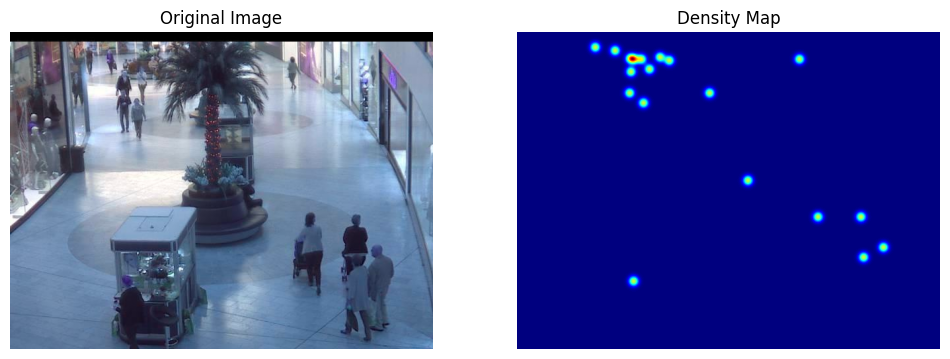

In [5]:
# Fetch the first batch
X_batch, y_batch = train_gen[0]

# Select the first example of the batch
image = X_batch[0]
density_map = y_batch[0].squeeze()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(density_map, cmap='jet')
axes[1].set_title('Density Map')
axes[1].axis('off')

plt.show()

# Training a CNN Model

In [6]:
# Prepare the model
model = Sequential()
model.add(Conv2D(16, (11, 11), activation='relu', input_shape=(480, 640, 3), padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(24, (9, 9), activation='relu', padding='same'))
model.add(Conv2D(16, (7, 7), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(16, (7, 7), activation='relu', padding='same'))
model.add(Conv2D(8, (5, 5), activation='relu', padding='same'))

# Replace upsampling with deconvolution
model.add(Conv2DTranspose(8, (5, 5), strides=(4, 4), padding='same', activation='relu'))

# Final layer to get the output density map
model.add(Conv2D(1, (1, 1), activation='relu', padding='same'))
model.compile(optimizer=Adam(learning_rate=0.003), loss='mean_squared_error', metrics=['mean_absolute_error'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    epochs=100,
    validation_data=valid_gen,
    callbacks=[early_stopping]
)

Epoch 1/100
50/50 [==============================] - 86s 2s/step - loss: 35.0427 - mean_absolute_error: 1.4576 - val_loss: 33.2600 - val_mean_absolute_error: 1.6225
Epoch 2/100
50/50 [==============================] - 59s 1s/step - loss: 29.3222 - mean_absolute_error: 1.5408 - val_loss: 28.6046 - val_mean_absolute_error: 1.5804
Epoch 3/100
50/50 [==============================] - 60s 1s/step - loss: 26.0667 - mean_absolute_error: 1.3995 - val_loss: 24.9846 - val_mean_absolute_error: 1.1633
Epoch 4/100
50/50 [==============================] - 64s 1s/step - loss: 23.4506 - mean_absolute_error: 1.2525 - val_loss: 22.5948 - val_mean_absolute_error: 1.2795
Epoch 5/100
50/50 [==============================] - 58s 1s/step - loss: 21.3481 - mean_absolute_error: 1.1821 - val_loss: 21.0224 - val_mean_absolute_error: 1.0812
Epoch 6/100
50/50 [==============================] - 60s 1s/step - loss: 20.0560 - mean_absolute_error: 1.1111 - val_loss: 19.2682 - val_mean_absolute_error: 1.0576
Epoch 7/10

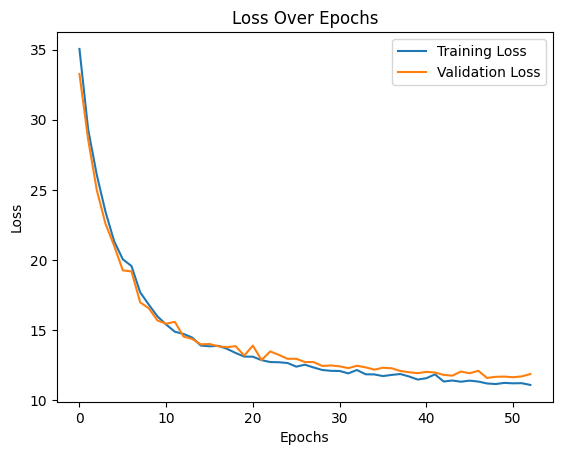

In [7]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 480, 640, 16)      5824      
                                                                 
 max_pooling2d (MaxPooling2  (None, 240, 320, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 240, 320, 24)      31128     
                                                                 
 conv2d_2 (Conv2D)           (None, 240, 320, 16)      18832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 120, 160, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 120, 160, 16)      1

## Model Evaluation 
### MSE and Pearson_

In [8]:
all_predictions = []
all_true_counts = []

for i in range(len(valid_gen)):
    batch_x, batch_y = valid_gen[i]
    batch_pred = model.predict(batch_x)
    all_predictions.extend(np.sum(batch_pred, axis=(1, 2, 3)) / scale) # Sum over each predicted density map
    all_true_counts.extend(np.sum(batch_y, axis=(1, 2, 3)) / scale)  # Sum over each true density map

# Compute metrics
mse = mean_squared_error(all_true_counts, all_predictions)
pearson_r, _ = stats.pearsonr(all_true_counts, all_predictions)

print(f'MSE: {mse:.1f}\nPearson r: {pearson_r:.2f}')

1/1 [==============================] - 0s 163ms/step
MSE: 5.6
Pearson r: 0.94


## Inference

1/1 [==============================] - 0s 22ms/step
The true head count is:  27.0 
The predicted head count is:  30.4397


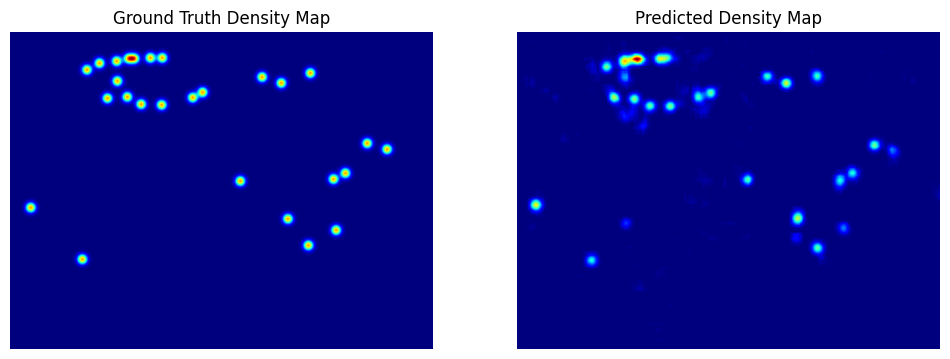

In [21]:
frame_id = 200

# Loading a sample image
image = cv2.imread(root + f'frames/frames/{df.image_name.iloc[frame_id - 1]}')

# Extract ground truth density map
true_density_map = np.array(create_density_map(image.shape, df.annotations.iloc[frame_id - 1]))
true_count = np.sum(true_density_map) / scale

# Prepare the image for prediction:
# Normalize the image
image_normalized = image / 255.0
# Expand dimensions to add the batch size
test_image = np.expand_dims(image_normalized, axis=0)
# Generate density map and head count
predicted_density_map = model.predict(test_image)
predicted_count = np.sum(predicted_density_map) / scale
# Remove batch dimension in the predicted density map
predicted_density_map = predicted_density_map.squeeze()

print('The true head count is: ', true_count, '\nThe predicted head count is: ', predicted_count)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(true_density_map, cmap='jet')
axes[0].set_title('Ground Truth Density Map')
axes[0].axis('off')

axes[1].imshow(predicted_density_map, cmap='jet')
axes[1].set_title('Predicted Density Map')
axes[1].axis('off')

plt.show()

## Testing on Custom Images

1/1 [==============================] - 0s 20ms/step
Predicted head count: 30.4397


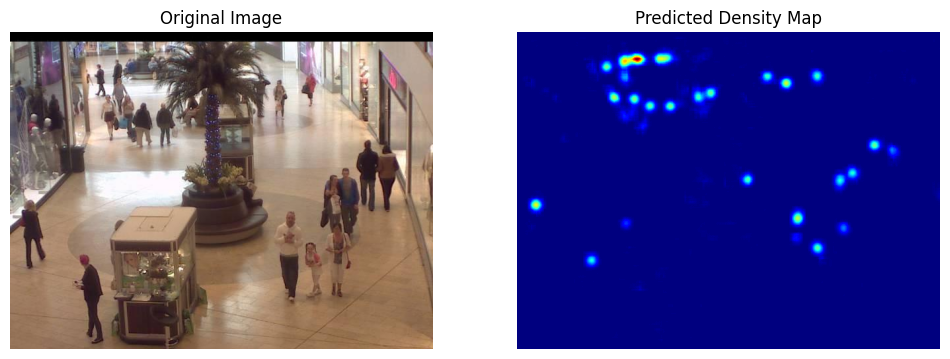

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the new image (ensure the path is correct)
image_path = '/kaggle/input/crowd-images/seq_000200.jpg'
image = cv2.imread(image_path)

# Resize the image if it is not the same size as the training images (480x640)
image_resized = cv2.resize(image, (640, 480))

# Normalize the image (same preprocessing as during training)
image_normalized = image_resized / 255.0

# Expand the dimensions to add the batch size (the model expects a batch of images)
test_image = np.expand_dims(image_normalized, axis=0)

# Get the predicted density map from the model
predicted_density_map = model.predict(test_image)

# Calculate the predicted count (sum the density map and scale it)
predicted_count = np.sum(predicted_density_map) / scale

# Squeeze the batch dimension for plotting
predicted_density_map = predicted_density_map.squeeze()

# Output the predicted count
print(f'Predicted head count: {predicted_count}')

# Plot the image and its predicted density map
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot original image
axes[0].imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
axes[0].set_title('Original Image')
axes[0].axis('off')

# Plot predicted density map
axes[1].imshow(predicted_density_map, cmap='jet')
axes[1].set_title('Predicted Density Map')
axes[1].axis('off')

plt.show()


## Save the Model

In [12]:
# save the model
model.save('crowd_count_trained.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
